# Chapter 7

## Initial Setup

In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# Initial imports.
import sys
import torch
import tiktoken
import time

import numpy as np

from typing import List, Tuple
from functools import partial
from importlib.metadata import version
from torch.utils.data import DataLoader

from gpt_download import download_and_load_gpt2

In [3]:
ancillar_path: str = "/llm_app/learning/build_large_language_models_from_scratch/"

if ancillar_path not in sys.path:
    sys.path.append(ancillar_path)

import ancillar as aux

In [4]:
pkgs: List[str] = [
    "numpy",  # PyTorch & TensorFlow dependency
    "matplotlib",  # Plotting library
    "tiktoken",  # Tokenizer
    "torch",  # Deep learning library
    "tqdm",  # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 1.26.3
matplotlib version: 3.10.0
tiktoken version: 0.8.0
torch version: 2.5.1+cpu
tqdm version: 4.67.1
tensorflow version: 2.20.0


## Preparing a Dataset for Supervised Instruction Fine-tuning

In [5]:
file_path = "./instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = aux.download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [6]:
print(">>> Example entry:\n", data[50])

>>> Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


In [7]:
print(">>> Another example entry:\n", data[999])

>>> Another example entry:
 {'instruction': "What is an antonym of 'complicated'?", 'input': '', 'output': "An antonym of 'complicated' is 'simple'."}


In [8]:
model_input = aux.format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [9]:
model_input = aux.format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


In [10]:
idx: int = np.random.randint(0, len(data))
print(f">>> Random example entry (index {idx}):\n")

model_input: str = aux.format_input(data[idx])
desired_response: str = f"\n\n### Response:\n{data[idx]['output']}"

print(model_input + desired_response)

>>> Random example entry (index 111):

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is a synonym of 'optimistic'?

### Response:
A synonym for 'optimistic' is 'hopeful'.


In [11]:
# Use 85% of the data for training.
train_portion = int(len(data) * 0.85)  

# Use 10% for testing.
test_portion = int(len(data) * 0.1) 

# Use remaining 5% for validation
val_portion = (len(data) - train_portion - test_portion)

train_data = data[:train_portion]
test_data = data[train_portion : train_portion + test_portion]
val_data = data[train_portion + test_portion :]

print(">>> Training set length:", len(train_data))
print(">>> Validation set length:", len(val_data))
print(">>> Test set length:", len(test_data))

>>> Training set length: 935
>>> Validation set length: 55
>>> Test set length: 110


## Organizing Data into Training Batches

In [12]:
tokenizer = tiktoken.get_encoding("gpt2")

print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [13]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

In [14]:
print(aux.custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


In [15]:
inputs, targets = aux.custom_collate_draft_2(batch)

print(inputs)
print()
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [16]:
inputs, targets = aux.custom_collate_fn(batch)

print(inputs)
print()
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])

tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [17]:
logits_1 = torch.tensor([
    [-1.0, 1.0],
    [-0.5, 1.5]
])

# Correct token indices to generate.
targets_1 = torch.tensor([0, 1]) 

# Compute the loss.
loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)

print(loss_1)

tensor(1.1269)


In [18]:
logits_2 = torch.tensor([
    [-1.0, 1.0],
    [-0.5, 1.5],
    [-0.5, 1.5]
])

targets_2 = torch.tensor([0, 1, 1])
loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)

print(loss_2)

tensor(0.7936)


In [19]:
targets_3 = torch.tensor([0, 1, -100])
loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)

print(loss_3)
print("loss_1 == loss_3:", (loss_1 == loss_3).item())

tensor(1.1269)
loss_1 == loss_3: True


## Creating Data Loaders for an Instruction Dataset

In [20]:
# Set the device to GPU, MPS, or CPU.
if torch.cuda.is_available():
    device = torch.device("cuda")

# Use MPS (Apple Silicon) if GPU is not available.
elif torch.backends.mps.is_available():
    
    # Use PyTorch 2.9 or newer for stable mps results.
    major, minor = map(int, torch.__version__.split(".")[:2])
    if (major, minor) >= (2, 9):
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: cpu


In [21]:
# Show it.
device

device(type='cpu')

In [22]:
customized_collate_fn = partial(
    aux.custom_collate_fn,
    device=device,
    allowed_max_length=1024
)

print(customized_collate_fn)

functools.partial(<function custom_collate_fn at 0x7f66e9eb3d90>, device=device(type='cpu'), allowed_max_length=1024)


In [23]:
# You can try to increase this number if parallel Python processes are supported by your operating system.
num_workers: int = 16

# Batch size for data loaders.
batch_size: int = 8

In [24]:
train_dataset = aux.InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

print(">>> Number of batches in the training set:", len(train_loader))

>>> Number of batches in the training set: 116


In [25]:
val_dataset = aux.InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

print(">>> Number of batches in the validation set:", len(val_loader))

>>> Number of batches in the validation set: 7


In [26]:
test_dataset = aux.InstructionDataset(test_data, tokenizer)
test_loader = aux.DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

print(">>> Number of batches in the test set:", len(test_loader))

>>> Number of batches in the test set: 14


In [27]:
for _ in range(9):

    # Grab a single batch from the training data loader.
    example_batch: Tuple[torch.Tensor, torch.Tensor] = next(iter(train_loader))

    # Unpack the batch into inputs and targets.
    inputs, targets = example_batch

    # Show shapes
    print(inputs.shape, targets.shape)

torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 74]) torch.Size([8, 74])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 64]) torch.Size([8, 64])


## Loading a Pretrained LLM

In [28]:
BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size: str = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")

In [29]:
settings, params = download_and_load_gpt2(
    model_size=model_size,
    models_dir="gpt2-from-scratch"
)

File already exists and is up-to-date: gpt2-from-scratch/355M/checkpoint
File already exists and is up-to-date: gpt2-from-scratch/355M/encoder.json
File already exists and is up-to-date: gpt2-from-scratch/355M/hparams.json
File already exists and is up-to-date: gpt2-from-scratch/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2-from-scratch/355M/model.ckpt.index
File already exists and is up-to-date: gpt2-from-scratch/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2-from-scratch/355M/vocab.bpe


In [30]:
model = aux.GPTModel(BASE_CONFIG)
aux.load_weights_into_gpt(model, params)
model.eval();

In [31]:
torch.manual_seed(123)

In [32]:
input_text: str = aux.format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [33]:
%%time

token_ids: torch.Tensor = aux.generate(
    model=model,
    idx=aux.text_to_token_ids(input_text, tokenizer),
    max_new_tokens=70,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256,
)

generated_text: str = aux.token_ids_to_text(token_ids, tokenizer)

CPU times: user 1min 22s, sys: 885 ms, total: 1min 23s
Wall time: 10.4 s


In [34]:
print(f">>> Number of input tokens: {aux.text_to_token_ids(input_text, tokenizer).shape}")
print(f">>> Number of generated tokens: {token_ids.shape}")

>>> Number of input tokens: torch.Size([1, 41])
>>> Number of generated tokens: torch.Size([1, 111])


In [35]:
# The generate function returns the combined input and output text.
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: '


In [36]:
response_text: str = generated_text[len(input_text):].strip()

print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the meal every day.'

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: '


## Fine-tuning the LLM on Instruction Data

In [37]:
%%time

model.to(device)
torch.manual_seed(123)

with torch.no_grad():
    train_loss = aux.calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = aux.calc_loss_loader(val_loader, model, device, num_batches=5)

print(">>> Training loss:", train_loss)
print(">>> Validation loss:", val_loss)

>>> Training loss: 3.82626953125
>>> Validation loss: 3.7622564315795897
CPU times: user 55.2 s, sys: 4.91 s, total: 1min
Wall time: 9.88 s


In [38]:
torch.manual_seed(456)

start_time = time.time()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
num_epochs: int = 2

train_losses, val_losses, tokens_seen = aux.train_model_simple(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    optimizer=optimizer, 
    device=device,
    num_epochs=num_epochs, 
    eval_freq=5,
    eval_iter=5,
    start_context=aux.format_input(val_data[0]), 
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60

print(f">>> Training completed in {execution_time_minutes:.2f} minutes.")

>>> Epoch: 1 (Step 000000): Train loss 2.663908, Validation loss 2.641310
>>> Epoch: 1 (Step 000005): Train loss 0.948885, Validation loss 1.079980
>>> Epoch: 1 (Step 000010): Train loss 0.867458, Validation loss 0.952118
>>> Epoch: 1 (Step 000015): Train loss 0.882253, Validation loss 0.927320
>>> Epoch: 1 (Step 000020): Train loss 0.840776, Validation loss 0.864306
>>> Epoch: 1 (Step 000025): Train loss 0.765618, Validation loss 0.839336
>>> Epoch: 1 (Step 000030): Train loss 0.806389, Validation loss 0.823288
>>> Epoch: 1 (Step 000035): Train loss 0.801090, Validation loss 0.802369
>>> Epoch: 1 (Step 000040): Train loss 0.715246, Validation loss 0.784385
>>> Epoch: 1 (Step 000045): Train loss 0.676468, Validation loss 0.765591
>>> Epoch: 1 (Step 000050): Train loss 0.635377, Validation loss 0.751378
>>> Epoch: 1 (Step 000055): Train loss 0.622911, Validation loss 0.761142
>>> Epoch: 1 (Step 000060): Train loss 0.556979, Validation loss 0.747881
>>> Epoch: 1 (Step 000065): Train loss

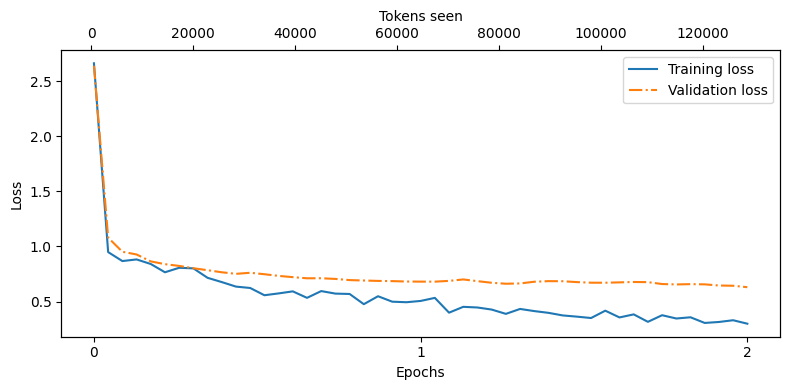

In [48]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
aux.plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Exercise 7.3 Fine-tuning on the Original Alpaca Dataset

## Extracting and Saving Responses